In [91]:
import os
import torch
import torchvision
from tqdm import tqdm
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pycocotools.coco import COCO

from utils import get_model_object_detection, InferDataset, compute_metrics, InferImgDataset, IoU

In [92]:
def get_transform():
    custom_transforms = []
    custom_transforms.append(torchvision.transforms.ToTensor())
    return torchvision.transforms.Compose(custom_transforms)

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))


root = os.getcwd() + '/../data/birds/annotations/all'
pathin = root + '/../full_coco_test.json'
n_batch = 4
num_classes = 2
num_epochs = 2

# select device (whether GPU or CPU)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


ds = InferDataset(root, pathin, get_transform())

dataloader = torch.utils.data.DataLoader(ds,
            batch_size = n_batch,
            shuffle = True,
            num_workers = 6,
            collate_fn = collate_fn)

loading annotations into memory...
Done (t=0.09s)
creating index...
index created!


In [93]:
model = get_model_object_detection(num_classes)
model.load_state_dict(torch.load(os.getcwd() + '/output_model_full_v2.pt')['model']) #if only CPU available 
model = model.to(device)
model.eval()
print('... model loaded.')

... model loaded.


In [94]:
data = next(iter(dataloader))

imgs, annotations = data
imgs = list(img.float().to(device) for img in imgs)
annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
pred = model(imgs)

boxes = []
gt_box = []
scores = []

for j, p in enumerate(pred):
    cond = p['scores'] > 0.6
    boxes.append(p['boxes'][cond])
    scores.append(p['scores'][cond])
    gt_box.append(annotations[j]['boxes'])

# Evaluation

In [95]:
sum_iou = 0
metrics = []

for data in dataloader:
    
    imgs, annotations = data
    imgs = list(img.float().to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]

    metrics.append(compute_metrics(model, imgs, annotations))

In [96]:
metrics_arr = np.array([m for m in metrics])
prec, rec, acc = np.mean(metrics_arr[:,1:], axis = 0)
miou = np.mean(metrics_arr[:,0][metrics_arr[:,0]!=0])

In [97]:
print('Precision', prec)
print('Recall', rec)
print('Accuracy', acc)
print('IoU', miou)

Precision 0.8246753246753247
Recall 0.8184523809523809
Accuracy 0.7169506990123873
IoU 0.7180528960951283


# Plot outputs

In [98]:
def plot_box(np_img, np_box):

    # Create a figure and axis
    fig, ax = plt.subplots(1)

    # Display the image
    ax.imshow(np_img)

    for obj in np_box:
        name = 'bird'
        rect = plt.Rectangle((obj[0], obj[1]), obj[2] - obj[0], obj[3] - obj[1], fill=False, edgecolor='red', linewidth=1)
        ax.add_patch(rect)

    plt.show()

In [131]:
data = next(iter(dataloader))

imgs, annotations = data
imgs = list(img.float().to(device) for img in imgs)
annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
pred = model(imgs)

boxes = []
gt_box = []
scores = []

for j, p in enumerate(pred):
    cond = p['scores'] > 0.6
    boxes.append(p['boxes'][cond])
    scores.append(p['scores'][cond])
    gt_box.append(annotations[j]['boxes'])

In [132]:
print('Number of boxes in groundtruth')
print([len(a['boxes']) for a in annotations])

Number of boxes in groundtruth
[2, 1, 6, 1]


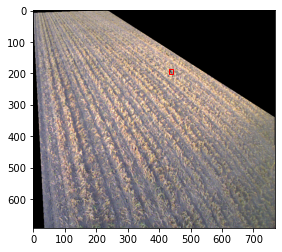

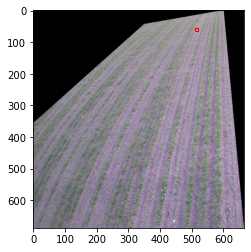

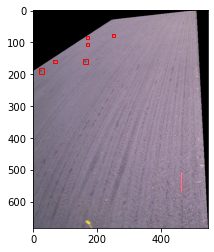

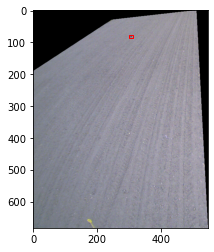

In [133]:
for i in range(len(boxes)):
    np_img = imgs[i].cpu().numpy().transpose(1,2,0)
    np_box = boxes[i].cpu().detach().numpy()
    np_gt_box = gt_box[i].cpu().detach().numpy()
    plot_box(np_img, np_box)

# Save output boxes

In [8]:
def get_box(prediction):
    
    # Initialize a flag to check if any predicted box matches a ground truth box
    results = np.zeros((len(prediction), len(prediction)))
    save = []
    remove = []

    # Iterate over the predicted boxes
    for i, box in enumerate(prediction):
        # Iterate over the ground truth boxes
        for j, pred in enumerate(prediction):
                # Compute IoU between the predicted box and the ground truth
            iou = IoU(box, pred)
            if iou > 0.1:
                if i not in remove:
                    save.append(i)
                if j not in save:
                    remove.append(j)
        
    return results, save

In [ ]:
res, save = get_box(boxes[0])

In [ ]:
res, out = get_box(boxes[0])

In [ ]:
np.unique(out)

In [ ]:
res[res == 1] = 0

for i, r in enumerate(res):
    print('hey')

In [ ]:
loc = np.arange(len(res))
loc = loc[loc!=0]

In [ ]:
res.shape

In [ ]:
list_arg = np.argwhere(res > 0.1)

In [ ]:
save = []
remove = []
for l in list_arg:
    s, r = l
    if s not in remove:
        save.append(s)
    if r not in save:
        remove.append(r)

In [ ]:
save, remove

# Notes

boxes : list of all boxes found
res: iou matrix of boxe with box
 --> if iou = 0 means box does not overlapp
 --> if iou > 0.5 means box overlapp : remove the one with the smallest score